# Setting up

In [1]:
# Basic imports
import pandas as pd                 # data handling
import numpy as np                  # numeric ops
import matplotlib.pyplot as plt     # plotting
import seaborn as sns               # nicer plots

# Statistical tests / modeling
from scipy import stats              # t-test
import statsmodels.api as sm         # ANOVA (ols)
import statsmodels.formula.api as smf


# Load cleaned CSV export from SQL
df = pd.read_csv("united_reviews.csv")
# Ensure RECOMMENDED is boolean and cabin class split available
df['RECOMMENDED'] = df['RECOMMENDED'].astype(int)
df['CABIN_GROUP'] = df['SEAT_TYPE'].apply(lambda s: 'Economy' if 'Economy' in str(s) else 'Non-Economy')

# Exploratory Data Analysis

Economy passengers generally report lower ratings, with the median around 1.5 and many responses clustered near the bottom, plus a few higher outliers. In contrast, Non-Economy cabins have a much higher median (about 2.5), a wider interquartile range, and ratings extending up to the maximum of 5. The distribution suggests that non-economy cabins consistently receive higher satisfaction scores, while economy experiences are more concentrated at the low end with occasional positive outliers.

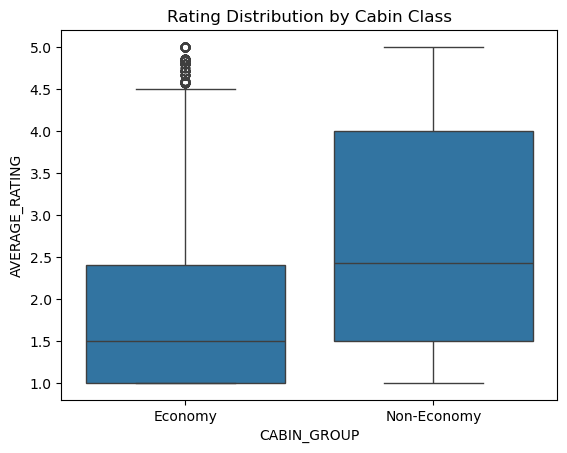

In [14]:
# Create a boxplot to visualize distribution of ratings by cabin class
sns.boxplot(x="CABIN_GROUP", y="AVERAGE_RATING", data=df)

# Add a title for clarity
plt.title("Rating Distribution by Cabin Class")

# Show the plot
plt.show()

# Quick distribution checks for key metrics

## Plot histograms for key metrics to inspect distributions

Most ratings are concentrated at the lowest score (1/5), especially for seat comfort and WiFi showing widespread dissatisfaction. 
A smaller share of mid-to-high ratings suggests only limited positive experiences, likely tied to premium cabins. 
Overall, poor service perception is broad and systemic across multiple factors.

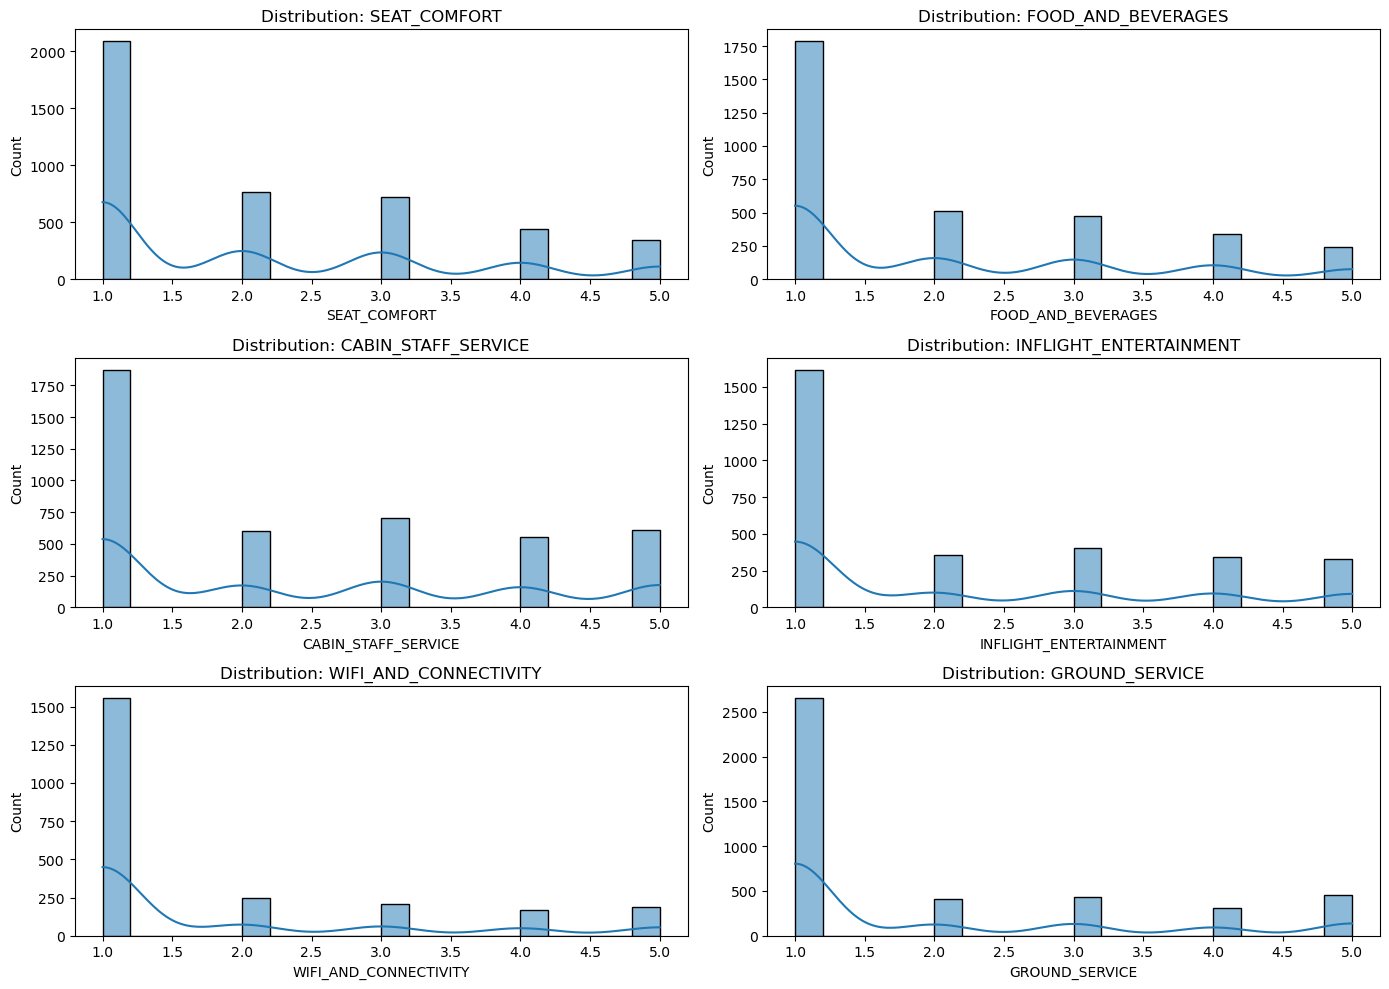

In [15]:
metrics = ['SEAT_COMFORT', 'FOOD_AND_BEVERAGES', 'CABIN_STAFF_SERVICE',
           'INFLIGHT_ENTERTAINMENT', 'WIFI_AND_CONNECTIVITY', 'GROUND_SERVICE']

plt.figure(figsize=(14, 10))
for i, m in enumerate(metrics, 1):
    plt.subplot(3, 2, i)                                # 3x2 grid
    sns.histplot(df[m].dropna(), kde=True, bins=20)     # histogram + KDE
    plt.title(f'Distribution: {m}')
plt.tight_layout()
plt.show()


## Boxplots to compare Economy vs Non-Economy distribution for each metric

Non-Economy passengers consistently rate higher across all service factors, with clear gaps in seat comfort, food, and cabin staff service. Economy scores cluster at the low end, especially for WiFi and ground services, showing deep dissatisfaction. This highlights a strong class divide in satisfaction, with premium cabins performing better but Economy driving the bulk of negative sentiment.

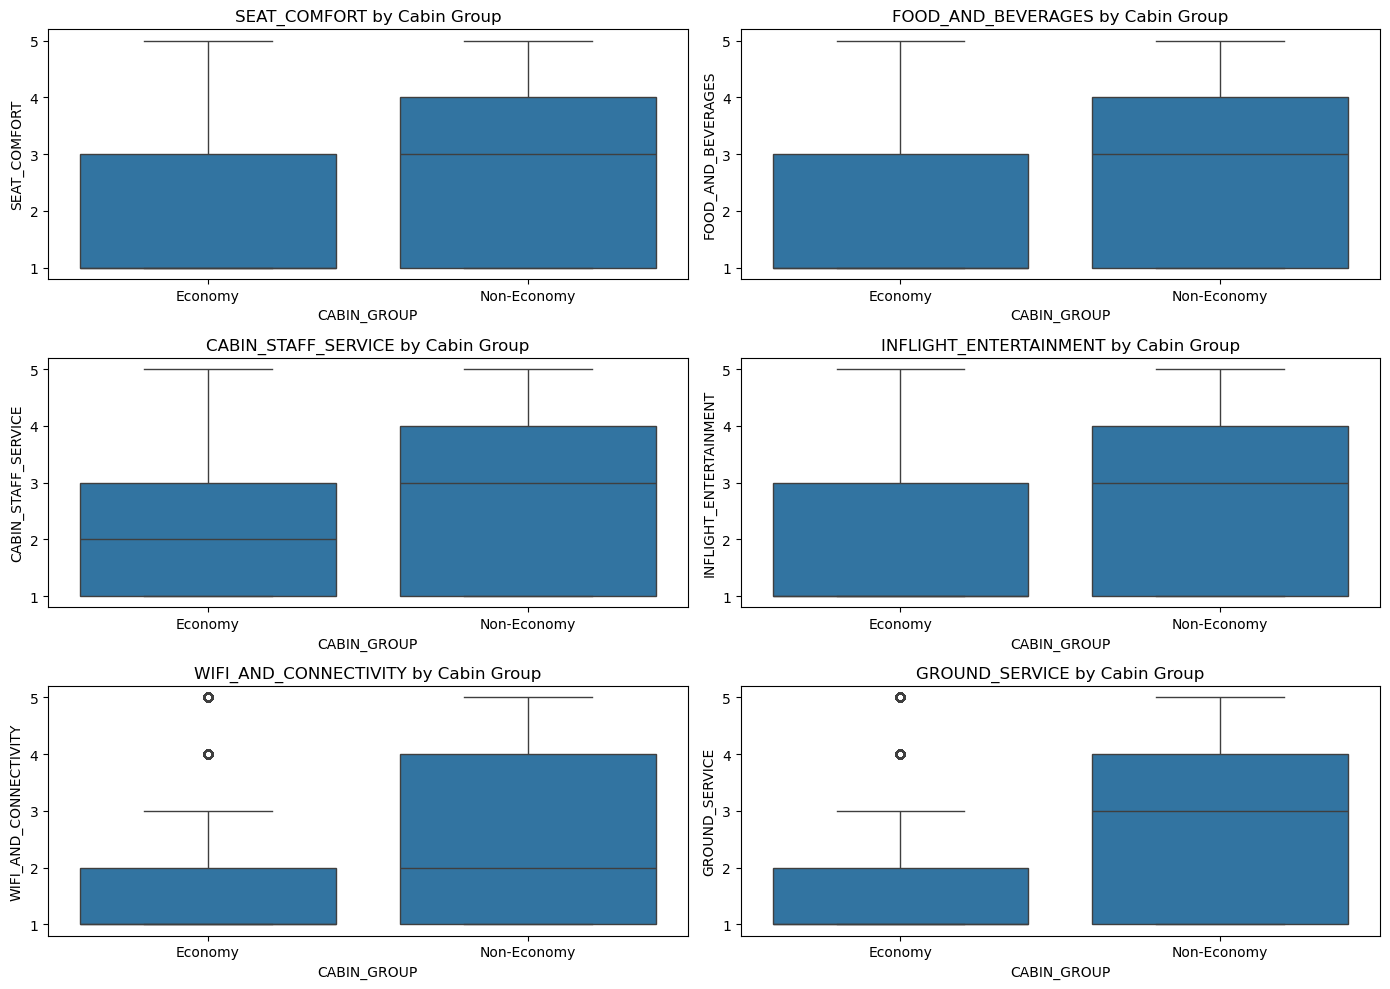

In [16]:
plt.figure(figsize=(14, 10))
for i, m in enumerate(metrics, 1):
    plt.subplot(3, 2, i)
    sns.boxplot(x='CABIN_GROUP', y=m, data=df)
    plt.title(f'{m} by Cabin Group')
plt.tight_layout()
plt.show()

# Heatmap

<bound method NDFrame.head of       REVIEW_ID  CUSTOMER_ID DATE_SUBMITTED_ID DATE_FLOWN_ID  \
0        105861        86095           00:00.0       00:00.0   
1         45428        86153           00:00.0       00:00.0   
2         56090        86398           00:00.0       00:00.0   
3        152119        86616           00:00.0       00:00.0   
4        128047        86768           00:00.0       00:00.0   
...         ...          ...               ...           ...   
4537     103168        56250           00:00.0       00:00.0   
4538     102517        57304           00:00.0       00:00.0   
4539      74462        57413           00:00.0       00:00.0   
4540     144618        86059           00:00.0       00:00.0   
4541     109884        86059           00:00.0       00:00.0   

      ORIGIN_LOCATION_ID  DESTINATION_LOCATION_ID  TRANSIT_LOCATION_ID  \
0                   3971                      864                 4740   
1                    567                     3971    

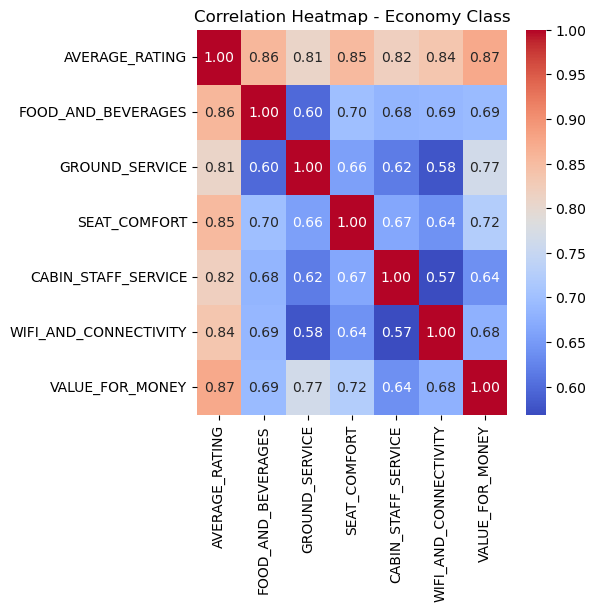

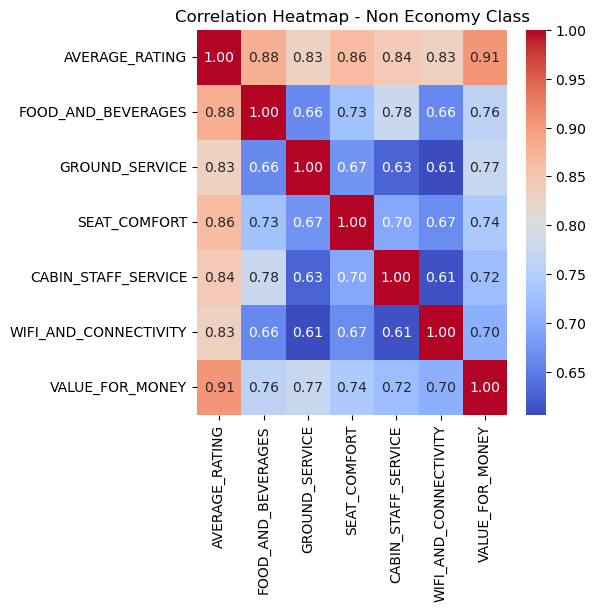

In [3]:
# Look at first 5 rows 
print(df.head)

# Drop Null values
df_cleaned = df.dropna()

# Process SEAT_TYPE
eco_df = df_cleaned[df_cleaned['SEAT_TYPE'] == 'Economy Class'] 
non_eco_df = df_cleaned[df_cleaned['SEAT_TYPE'] != 'Economy Class']

# Select relevant columns for correlation calculation
numeric_cols = ['AVERAGE_RATING', 'FOOD_AND_BEVERAGES', 'GROUND_SERVICE', 
                'SEAT_COMFORT', 'CABIN_STAFF_SERVICE', 'WIFI_AND_CONNECTIVITY',
                'VALUE_FOR_MONEY']
                
# Correlation matrix for Economy Class
eco_corr = eco_df[numeric_cols].corr()

# Correlation matrix for Non-Economy Class
non_eco_corr = non_eco_df[numeric_cols].corr()


# Create heatmap for Economy Class
plt.figure(figsize=(5, 5))
sns.heatmap(eco_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Heatmap - Economy Class")
plt.show()

# Create heatmap for Non-Economy Class
plt.figure(figsize=(5, 5))
sns.heatmap(non_eco_corr, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Heatmap - Non Economy Class")
plt.show()

# Two-sample t-test: Economy vs Non-Economy

All satisfaction metrics show statistically significant differences (p < 0.001) between Economy and Non-Economy passengers. Non-Economy ratings are consistently higher, with the largest gaps in seat comfort, ground service, and inflight entertainment. This confirms that the class divide observed in the boxplots is not random but a systematic and meaningful difference.

In [17]:
# Function for independent t-test (Welch's t-test — does not assume equal variance)
def ttest_econ_vs_non(df, metric):
    econ = df.loc[df['CABIN_GROUP']=='Economy', metric].dropna()
    non = df.loc[df['CABIN_GROUP']=='Non-Economy', metric].dropna()
    tstat, pvalue = stats.ttest_ind(econ, non, equal_var=False)  # Welch's t-test
    return tstat, pvalue, len(econ), len(non)

# Run tests for all metrics and display
results = []
for m in metrics:
    t, p, n_e, n_ne = ttest_econ_vs_non(df, m)
    results.append({'metric': m, 't_stat': t, 'p_value': p, 'n_econ': n_e, 'n_non': n_ne})

pd.DataFrame(results)


,metric,t_stat,p_value,n_econ,n_non
0,SEAT_COMFORT,-14.575802,5.281659e-42,3803,554
1,FOOD_AND_BEVERAGES,-9.828914,2.229908e-21,2831,516
2,CABIN_STAFF_SERVICE,-9.744839,3.925401e-21,3790,554
3,INFLIGHT_ENTERTAINMENT,-9.963109,9.836586e-22,2593,459
4,WIFI_AND_CONNECTIVITY,-6.592666,1.755903e-10,2103,274
5,GROUND_SERVICE,-12.133414,1.525889e-30,3750,509


# ANOVA

The results show a very large F-statistic (113.2) with an extremely small p-value (1.38e-70), indicating that differences in seat comfort across seat types are highly statistically significant. In other words, not all seat categories provide the same level of comfort: seat type is a strong determinant of comfort ratings.

In [18]:
# Compare multiple seat categories
# Example for SEAT_COMFORT
model = smf.ols('SEAT_COMFORT ~ C(SEAT_TYPE)', data=df).fit()  # OLS with categorical seat type
anova_table = sm.stats.anova_lm(model, typ=2)                 # ANOVA table
print(anova_table)


                   sum_sq      df           F        PR(>F)
C(SEAT_TYPE)   548.398170     3.0  113.208332  1.382293e-70
Residual      7025.632599  4351.0         NaN           NaN
